### Preliminary
* get model (trained) and test it
* graph the result
* This uses the difference between days to establish the data (and loss)
* reads json file in

In [4]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
import subprocess
import seaborn as sns
import json

#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

84
(172, 5)
(172, 5)
(172, 74)


In [7]:
def find_zero(lst):
    numzero = 0
    for i in lst:
        if i ==0:
            numzero += 1
    return(numzero)

# graph number of days zero
cutoff = 25 # at most = 0
lstzero = []
skip_countries = []
for i in range(len(countries)):
    numz = find_zero(casesA[i,:].tolist())
    lstzero.append(numz)
    if numz > cutoff:
        skip_countries.append(i)

#sns.distplot(np.array(lstzero));

In [8]:
len(skip_countries)

149

In [9]:
def get_diff(arr):
    lst = arr.tolist()
    difflst = []
    for i in range(len(lst)):
        if i == 0:
            continue
        # start
        difflst.append(lst[i]-lst[i-1])
    return(np.array(difflst))

def clear_zero(nparray):
    # return the np array that contains only 1 0:
    lst = nparray.tolist()
    #print(len(lst))
    ind = 0
    splitInd = 0
    while(lst[ind]==0):
        splitInd += 1
        ind += 1
    #print(splitInd)
    return(np.array(lst[splitInd:]))

t_days = 25 # number of days used to test 
pred_days = test_d
total_days = case_train.shape[1]

country_train_X = []
country_train_Y = []

country_valid_X = []
country_valid_Y = []

country_test_X = []
country_test_Y = []

diffData = []
for i in range(len(countries)):
    print(countries[i] + " "+ str(i))
    
    if i in skip_countries:
        country_train_X.append(0)
        country_train_Y.append(0)

        country_valid_X.append(0)
        country_valid_Y.append(0)

        country_test_X.append(0)
        country_test_Y.append(0)
        diffData.append(0)
        continue # too little data 
        
    # split dataset
    cur_c = [] # current country 
    out = []
    
    cur_v = [] # current country 
    out_v = []
    
    cur_t = [] # current country 
    out_t = []
    
    newcase1 = clear_zero(case_train[i,:])
    newcase = get_diff(newcase1)
    total_days = newcase.shape[0]
    diffData.append(newcase)
    print(total_days)
    for j in range(total_days-pred_days*2-t_days): 
        
        #print(j)
        #print(case_train[i,j:j+t_days].shape)
        #print(len(case_train[i,j+t_days]))
        cur_c.append(newcase[j:j+t_days])
        #print(str(j))
        out.append(newcase[j+t_days:j+t_days+pred_days])
        #print(len(cur_c))
    
    country_train_X.append(cur_c)
    country_train_Y.append(out)
    
    country_valid_X.append(newcase[total_days-t_days-test_d*2:total_days-test_d*2])
    print(newcase[total_days-t_days-test_d*2:total_days-test_d*2].shape)
    country_valid_Y.append(newcase[total_days-test_d*2:total_days-test_d])
    print(newcase[total_days-test_d*2:total_days-test_d].shape)
    
    country_test_X.append(newcase[total_days-test_d-t_days:total_days-test_d])
    country_test_Y.append(newcase[total_days-test_d:])
    
    # the best way to check this
    #testlist = 


Burundi 0
Djibouti 1
Eritrea 2
Ethiopia 3
Kenya 4
Madagascar 5
Malawi 6
Mauritius 7
Mozambique 8
Rwanda 9
Seychelles 10
Somalia 11
South Sudan 12
Uganda 13
Tanzania 14
Zambia 15
Zimbabwe 16
Angola 17
Cameroon 18
Central African Republic 19
Chad 20
Equatorial Guinea 21
Gabon 22
Sao Tome and Principe 23
Botswana 24
Eswatini 25
Namibia 26
South Africa 27
Benin 28
Burkina Faso 29
Cabo Verde 30
Gambia 31
Ghana 32
Guinea 33
Guinea-Bissau 34
Liberia 35
Mali 36
Mauritania 37
Niger 38
Nigeria 39
Senegal 40
Sierra Leone 41
Togo 42
Algeria 43
Egypt 44
50
(25,)
(5,)
Libya 45
Morocco 46
Sudan 47
Tunisia 48
Western Sahara 49
Armenia 50
Azerbaijan 51
Bahrain 52
Cyprus 53
Georgia 54
Iraq 55
Israel 56
Jordan 57
Kuwait 58
Lebanon 59
Oman 60
Qatar 61
Saudi Arabia 62
Syria 63
Turkey 64
United Arab Emirates 65
66
(25,)
(5,)
Yemen 66
Kazakhstan 67
Kyrgyzstan 68
Uzbekistan 69
Afghanistan 70
Bangladesh 71
Bhutan 72
India 73
65
(25,)
(5,)
Iran 74
Maldives 75
Nepal 76
70
(25,)
(5,)
Pakistan 77
Sri Lanka 78
68
(

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return y_pred.view(-1)

    


In [30]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred, y)
            test_loss += loss.item() 
            
    return pred,test_loss




In [33]:
def find_min_file(path):
    with open(path,'r') as f1:
        doc = f1.readlines()
        minimum_err = 1e20
        for line in doc:
            line = line.replace('\n','')
            wdr = line.split(',')
            err = float(wdr[1])
            if err < minimum_err:
                minimum_err = err
    return(minimum_err)

In [34]:
def find_min_val(country):
    
    lr_list = [0.1,0.01,0.001,0.005,1e-4,5e-4,1e-5,1e-6]
    hidden_lst = [1,2,3,4,5]
    hState_lst = [30,50,100,200,300]
    
    model_name = country
    output_file_path = "./offline/" + model_name + "/training/"
    directory = os.path.dirname(output_file_path)
    best_param = [0,0,0]
    best_verror = 1e20
    
    for j in range(len(lr_list)):
        for k in range(len(hidden_lst)): # hidden layer
            for m in range(len(hState_lst)): # hidden state
                
                learning_rate = lr_list[j]
                hidden_dim = hState_lst[m]
                num_layers = hidden_lst[k]
    
                #train_error = open(output_directory + "training_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "a")
                fname = output_file_path + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt"
                #lastline = subprocess.check_output(['tail', '-1', fname]).decode("utf-8")  #(output_directory + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "r")
                
                err = find_min_file(fname)
                
                if err < best_verror:
                    best_verror = err
                    best_param = [learning_rate,hidden_dim,num_layers]
    
    print(best_verror)
    return(best_param)

In [ ]:
country_train_X[88][0].shape
country_train_X[81][0].shape

In [35]:
import matplotlib.pyplot as plt

def graph_country(index,prediction,outdir):
    
    # produce projection closeup & general graph
    # with label & title
    #print(prediction)
    newpred = prediction#.tolist()
    
    # general trend
    x = np.linspace(1, len(casesA[index,:].tolist()), len(casesA[index,:].tolist()))
    y_real = casesA[index,:]
    y_pred = casesA[index,:days-test_d].tolist()
    #print(len(y_pred))
    y_pred.extend(newpred)
    #print(len(y_pred))
    #print(len(y_real))
    y_pred = np.array(y_pred)
    plt.figure(index)
    plt.plot(x, y_real,':', label = "real")
    plt.plot(x, y_pred, label = "prediction")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" trend")
    plt.savefig(outdir+countries[i]+"_general")
    plt.show()
    # specific plot
    x = np.linspace(1, len(casesA[index,days-test_d:].tolist()), len(casesA[index,days-test_d:].tolist()))
    y_real = casesA[index,days-test_d:]
    y_pred = newpred
    plt.figure(index*2)
    plt.plot(x, y_real,':', label = "real")
    plt.plot(x, y_pred, label = "prediction")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" 5 days prediction")
    plt.savefig(outdir+countries[i]+"_specific")    
    plt.show()

In [14]:

b = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16819754465224315, 0.16819754465224315, 0.25229631697836474, 0.25229631697836474, 0.25229631697836474]
print(len(b))
print(b)
print(len(b))

b[-3]

74
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16819754465224315, 0.16819754465224315, 0.25229631697836474, 0.25229631697836474, 0.25229631697836474]
74


0.25229631697836474

In [15]:

import json
with open("./country_summary_6.js",'r') as outfile:
    dt = json.load(outfile)

In [18]:
test_d

5

In [21]:
def chain_val(start,lst):
    newlst = []
    for i in range(len(lst)):
        if i == 0:
            newlst.append(lst[i]+start)
            continue
        newlst.append(newlst[i-1] + lst[i])
    return(newlst)

chain_val(1,[2,3,4])

[3, 6, 10]

In [22]:
{"*Taiwan":0,"US":0,"Italy":0, "Korea, South":0,"Germany":0,"Japan":0}

{'*Taiwan': 0,
 'US': 0,
 'Italy': 0,
 'Korea, South': 0,
 'Germany': 0,
 'Japan': 0}

Directory ./graph_offline6/ exists


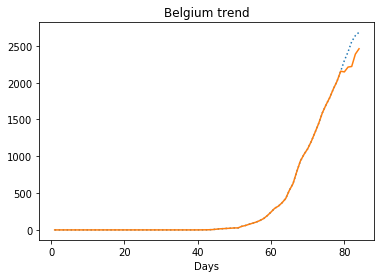

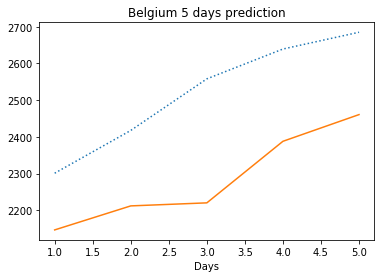

[2146.43012284 2211.88643693 2220.1613984  2387.92937325 2460.68373727] [2231.22069576 2333.81249774 2453.22970037 2575.92569903 2719.24359901]
Belgium
35714.41191067415


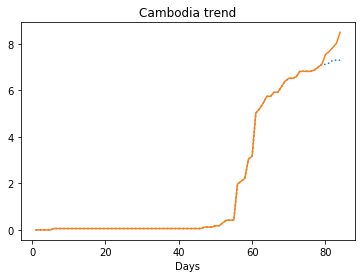

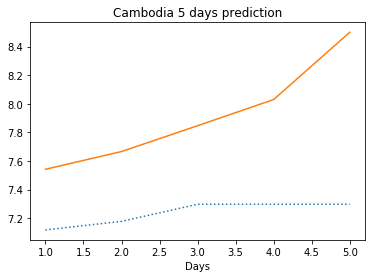

[7.54165354 7.66586802 7.84652614 8.02961467 8.50020451] [7.23728794 7.23728794 7.29710024 7.53634943 7.53634943]
Cambodia
0.35010306890432885


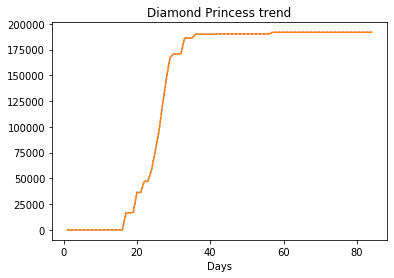

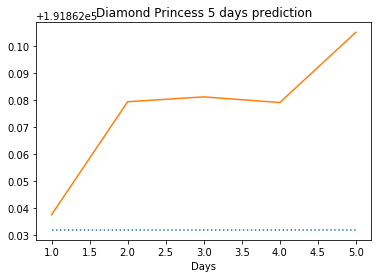

[191862.03743416 191862.0793123  191862.08111688 191862.07902953
 191862.10507873] [191862.03179736 191862.03179736 191862.03179736 191862.03179736
 191862.03179736]
Diamond Princess
0.0024645790398295647


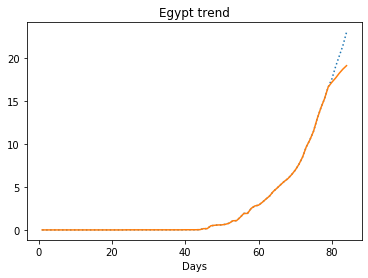

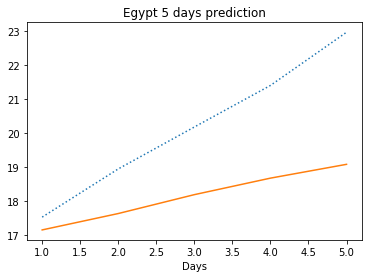

[17.15472945 17.63619249 18.1913427  18.67633652 19.08217572] [17.1301146  17.80437468 18.6447568  19.81738301 20.64799325]
Egypt
0.7976494184845485


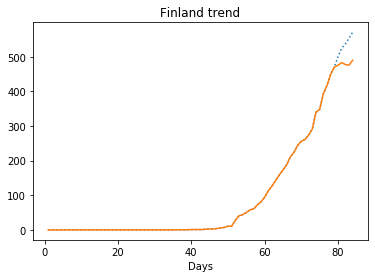

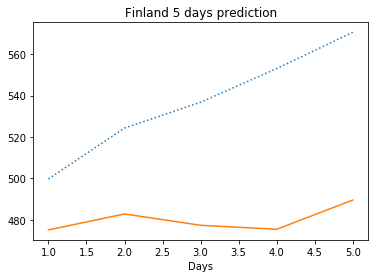

[475.19082068 482.88398836 477.42016409 475.49621962 489.59032343] [482.06731255 487.1208074  500.11550845 517.62225848 565.81094154]
Finland
1632.900241320107


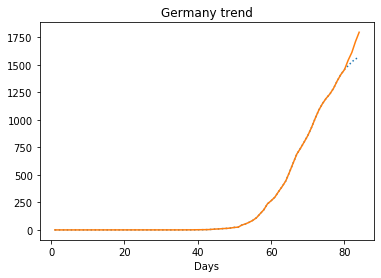

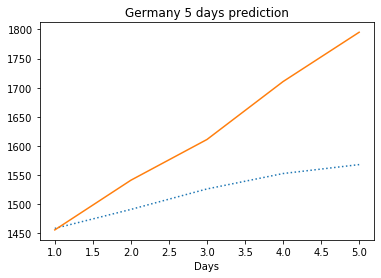

[1455.61593678 1540.98658803 1610.96911671 1710.45753529 1795.20418599] [1469.30289154 1541.67952215 1624.2967776  1700.26598173 1759.14360686]
Germany
353.9345128529333


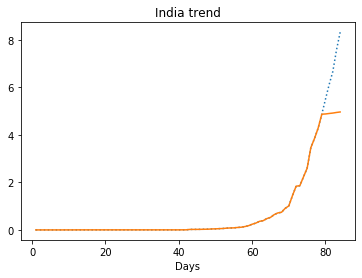

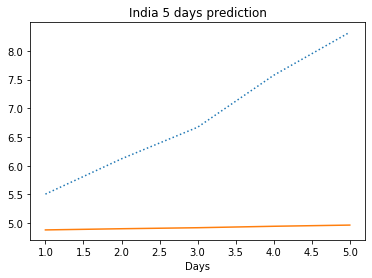

[4.8825208  4.90312503 4.92069835 4.94592316 4.96662474] [4.97896967 5.41447553 5.80940181 5.82679306 6.19998028]
India
0.6715346438230414


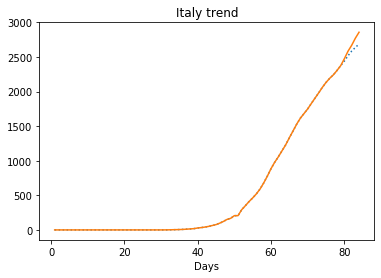

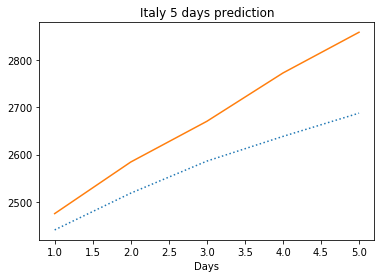

[2475.2646856  2584.23967645 2670.19964501 2772.22751519 2858.28852746] [2442.51621229 2521.60743398 2598.81316857 2674.64613625 2754.11776322]
Italy
6092.992591225653


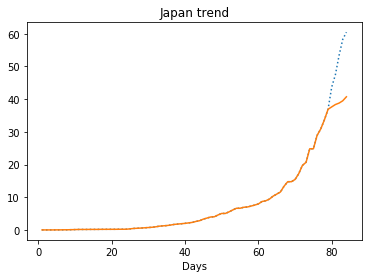

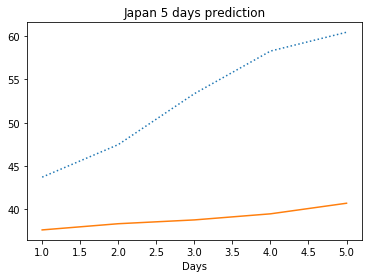

[37.632513   38.3476146  38.7870105  39.48871536 40.71176929] [37.58802231 39.36700948 41.87340474 42.83801112 46.96526136]
Japan
12.17818398659469


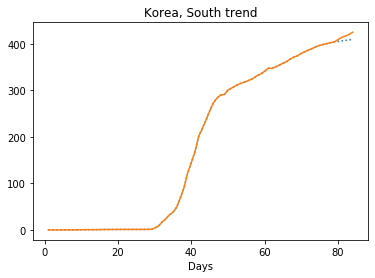

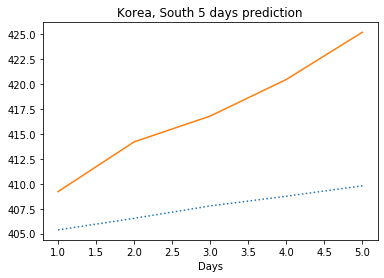

[409.20889223 414.19492376 416.77825678 420.44708288 425.17871845] [409.17311188 413.09105692 416.54350354 419.87957556 423.52597985]
Korea, South
0.8657041488114217


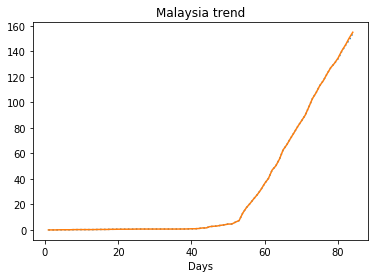

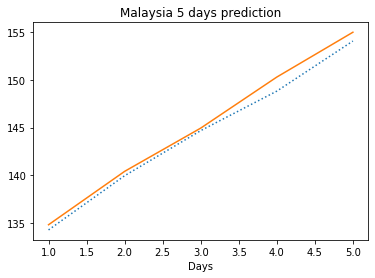

[134.81912757 140.41733314 144.95224382 150.30482961 155.00406648] [134.95643577 139.34375579 145.77025273 152.47481925 157.10931224]
Malaysia
2.1962950439251236


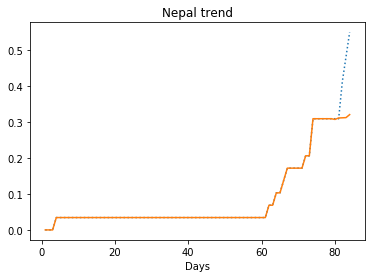

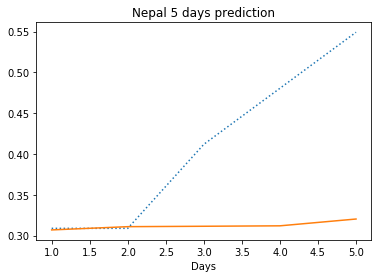

[0.30696242 0.31094182 0.31143872 0.31197727 0.32031107] [0.30888762 0.30888762 0.34320847 0.34320847 0.44617101]
Nepal
0.0035666713284360427


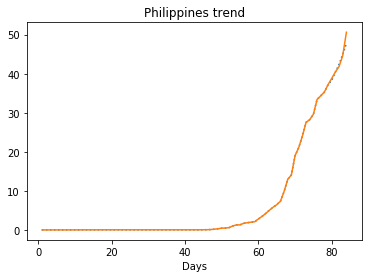

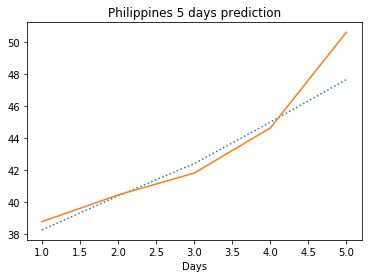

[38.79761102 40.46371307 41.82757737 44.64282825 50.61382558] [42.10580493 44.17733023 47.11579343 50.62917334 51.32272366]
Philippines
17.807838480219687


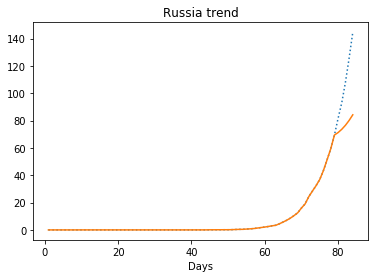

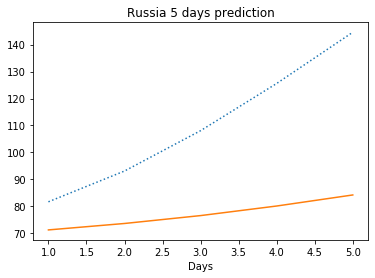

[71.2205857  73.60924232 76.5402888  80.09411084 84.19736659] [72.85462255 75.86967465 81.15286821 85.27115528 89.25924692]
Russia
16.29598824160123


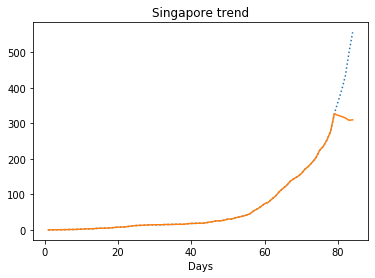

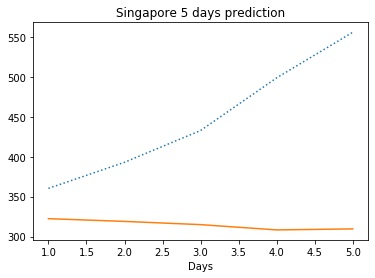

[322.376492   318.95188234 314.913784   308.28997037 309.56625459] [334.5104729  347.1593104  355.53489199 366.64535736 379.4651251 ]
Singapore
2176.8340389135874


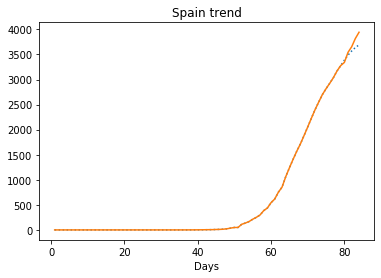

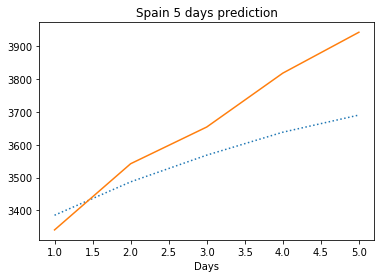

[3340.4621809  3542.07248669 3653.91774731 3818.06551342 3942.60740642] [3447.54055093 3622.81674729 3792.78867316 3945.37200261 4094.42628112]
Spain
15305.29198008441


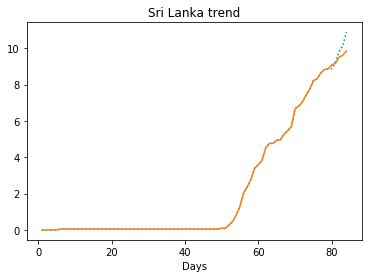

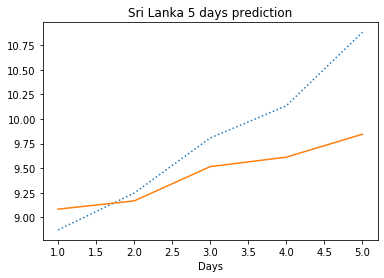

[9.08391599 9.16766889 9.51597382 9.61218367 9.84539307] [ 9.85371207  9.99381224 10.22731253 10.60091299 10.92781339]
Sri Lanka
0.7860642010267108


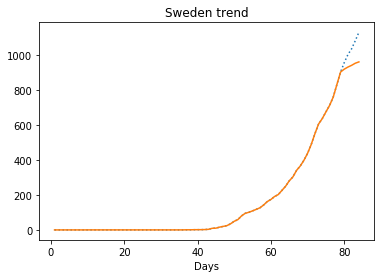

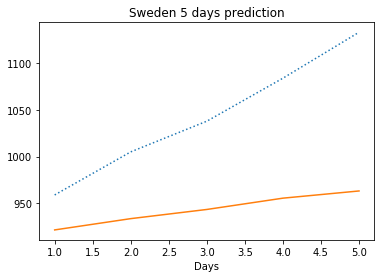

[921.52671309 933.61033221 943.44294615 955.53911944 963.24974509] [ 945.41486662  996.11160015 1057.60119296 1113.34779642 1144.24111842]
Sweden
15034.122687974319


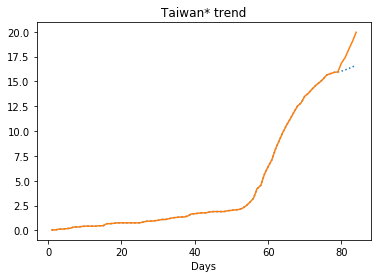

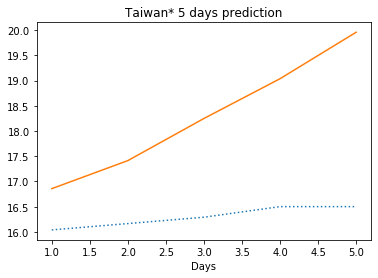

[16.85705974 17.41371073 18.24884351 19.03711363 19.95801481] [16.62693278 16.9208432  17.34071524 17.71860008 18.01251051]
Taiwan*
1.3288077465371726


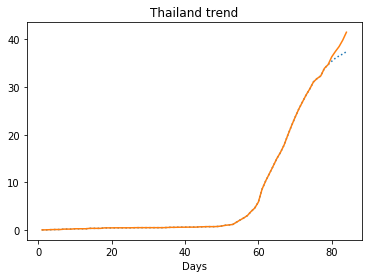

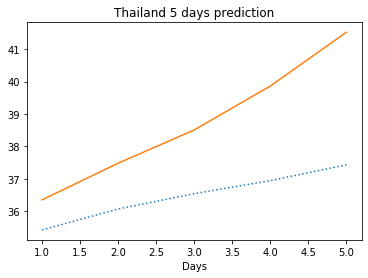

[36.35585318 37.48533259 38.50948141 39.86280356 41.5199276 ] [36.53296176 38.25215996 39.74213173 41.21777685 42.49284885]
Thailand
0.9842693738795696


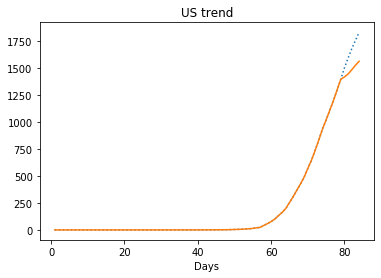

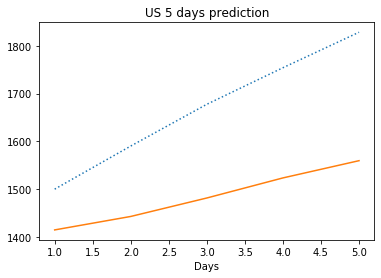

[1414.8010795  1442.97779916 1481.60943292 1523.58982919 1559.65797876] [1473.63774882 1549.77006982 1641.58202359 1737.72626896 1838.22999604]
US
32782.871228634336


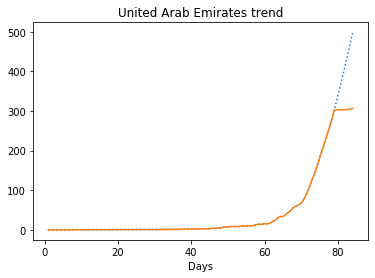

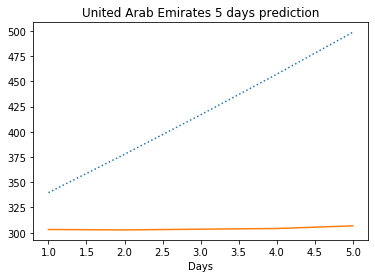

[303.16813784 302.75460105 303.48086124 304.15960841 306.77256112] [307.67208606 322.83830785 344.07101836 368.33697323 392.70403624]
United Arab Emirates
2714.830850644452


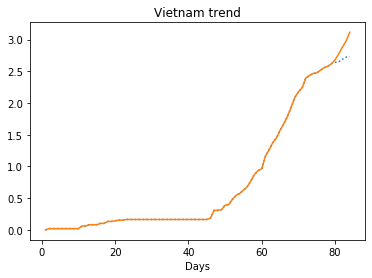

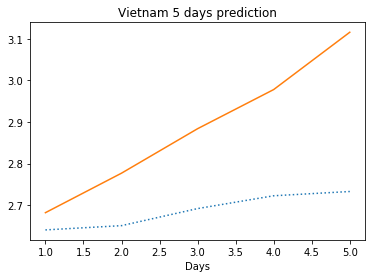

[2.68174907 2.77684616 2.88390189 2.97810543 3.11604223] [2.71218257 2.77382308 2.92792436 2.96901804 2.9998383 ]
Vietnam
0.0032918497742754895


In [37]:
len(dt)

lr_dict=dict()
layerLst = []
stateLst = []
momentumLst = []
mseLst = []
nloss = []

keyCountry = {"*Taiwan":0,"US":0,"Italy":0, "Korea, South":0,"Germany":0,"Japan":0}

country_result = dict()
graph_dir = "./graph_offline6/"
directory = os.path.dirname(graph_dir)
if not os.path.exists(directory):
    print("Creating directory %s" % graph_dir)
    os.makedirs(directory)
else:
     print("Directory %s exists" % graph_dir)

for key,item in dt.items():
    # [hyperparam, [prediction, truth], error]
    # [lr, layer, state, momentum]
    ind = countries.index(key)
    
    # hyper-param
    if item[0][0] in lr_dict:
        lr_dict[item[0][0]] += 1
    else:
        lr_dict[item[0][0]] = 1
    layerLst.append(item[0][1])
    stateLst.append(item[0][2])
    momentumLst.append(item[0][3])
    
    
    # get original
    startv = casesA[ind,-test_d-1]
    pred = chain_val(startv,math.exp(item[1][0])-1)
    y = chain_val(startv,math.exp(item[1][1])-1)
    
    # graph
    graph_country(ind,pred,graph_dir)
    
    # mse calculation
    a = np.array(pred)
    b = np.array(y)
    print(a,b)
    mse = ((a-b)**2).mean()
    print(key)
    print(str(mse))
    keyCountry[key] = mse
    mseLst.append(mse)
    nloss.append(mse/max(y))

### Show result:
* distribution of the hyper-parameter
* MSE distribution (histogram)
* MSE normalized to max of value (histogram)

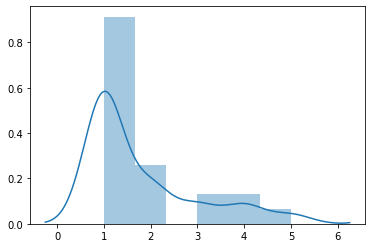

In [30]:
sns.distplot(np.array(layerLst));


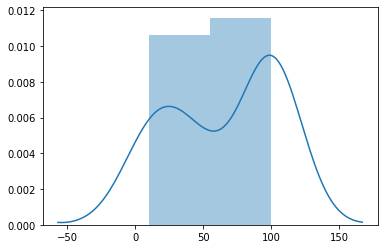

In [31]:
sns.distplot(np.array(stateLst));

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

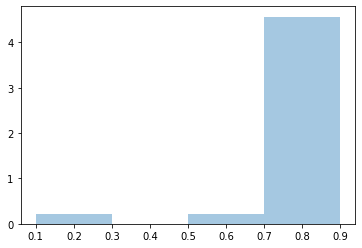

In [32]:
sns.distplot(np.array(momentumLst));

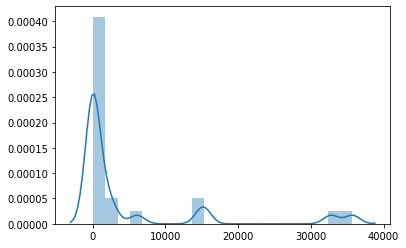

In [33]:
sns.distplot(np.array(mseLst));

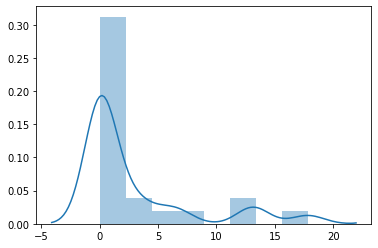

In [38]:

sns.distplot(np.array(nloss));

In [34]:
keyCountry

{'*Taiwan': 0,
 'US': 32782.871228634336,
 'Italy': 6092.992591225653,
 'Korea, South': 0.8657041488114217,
 'Germany': 353.9345128529333,
 'Japan': 12.17818398659469,
 'Belgium': 35714.41191067415,
 'Cambodia': 0.35010306890432885,
 'Diamond Princess': 0.0024645790398295647,
 'Egypt': 0.7976494184845485,
 'Finland': 1632.900241320107,
 'India': 0.6715346438230414,
 'Malaysia': 2.1962950439251236,
 'Nepal': 0.0035666713284360427,
 'Philippines': 17.807838480219687,
 'Russia': 16.29598824160123,
 'Singapore': 2176.8340389135874,
 'Spain': 15305.29198008441,
 'Sri Lanka': 0.7860642010267108,
 'Sweden': 15034.122687974319,
 'Taiwan*': 1.3288077465371726,
 'Thailand': 0.9842693738795696,
 'United Arab Emirates': 2714.830850644452,
 'Vietnam': 0.0032918497742754895}